In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 4.5703345390527765
(0, 5)
(5, 6)
(6, 11)
(11, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1078.09it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1068.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 974.01it/s]


In [6]:
from dataset import optDatasetConstrs
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 724.56it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
from tqdm import tqdm

def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### Exact Method 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, warmstart=True, conecheck=True, processes=8)

Num of cores: 8


In [13]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  53.4202%, Val Regret:  51.0992%


Epoch    1, Loss:  -0.9993:  10%|█████▌                                                 | 2/20 [00:13<01:36,  5.35s/it]

Epoch   2, Train Regret:   5.5337%, Val Regret:   4.1997%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:20<01:05,  4.09s/it]

Epoch   4, Train Regret:   2.7056%, Val Regret:   1.7132%


Epoch    5, Loss:  -1.0000:  30%|████████████████▌                                      | 6/20 [00:27<00:52,  3.76s/it]

Epoch   6, Train Regret:   1.8889%, Val Regret:   1.4682%


Epoch    7, Loss:  -1.0000:  40%|██████████████████████                                 | 8/20 [00:34<00:43,  3.61s/it]

Epoch   8, Train Regret:   1.7588%, Val Regret:   1.0658%


Epoch    9, Loss:  -1.0000:  50%|███████████████████████████                           | 10/20 [00:42<00:35,  3.55s/it]

Epoch  10, Train Regret:   1.5882%, Val Regret:   0.8502%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [00:49<00:28,  3.58s/it]

Epoch  12, Train Regret:   1.4049%, Val Regret:   0.5491%


Epoch   13, Loss:  -0.9999:  70%|█████████████████████████████████████▊                | 14/20 [00:57<00:21,  3.61s/it]

Epoch  14, Train Regret:   1.3329%, Val Regret:   0.6337%


Epoch   15, Loss:  -1.0000:  80%|███████████████████████████████████████████▏          | 16/20 [01:04<00:14,  3.57s/it]

Epoch  16, Train Regret:   1.3343%, Val Regret:   1.0003%


Epoch   17, Loss:  -1.0000:  90%|████████████████████████████████████████████████▌     | 18/20 [01:11<00:07,  3.52s/it]

Epoch  18, Train Regret:   1.2708%, Val Regret:   0.9067%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.88s/it]


Epoch  19, Loss:  -1.0000, Train Regret:   1.1796%, Val Regret:   1.1871%

Evaluation:
Test Regret: 0.9906%
Training Elapsed Time: 42.27 Sec


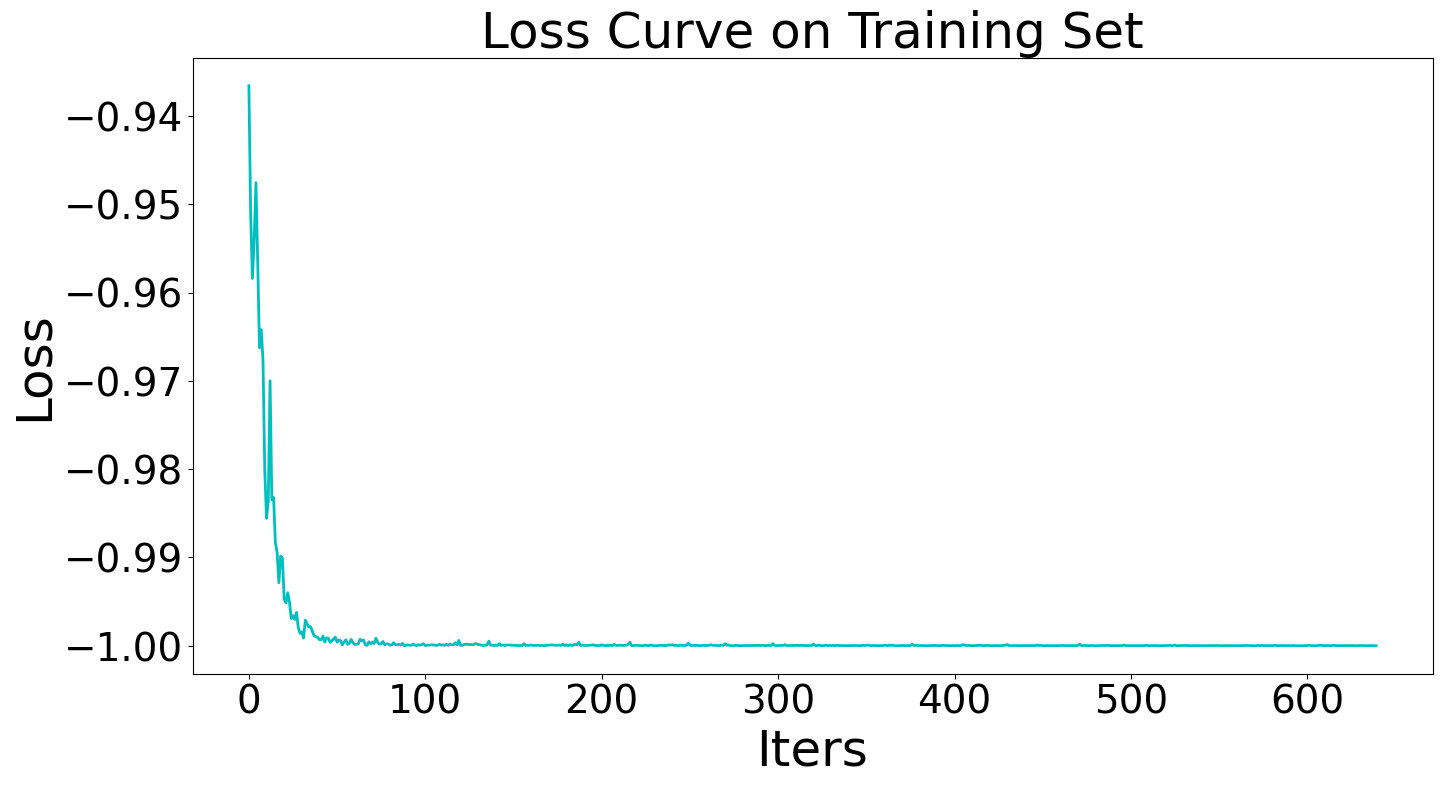

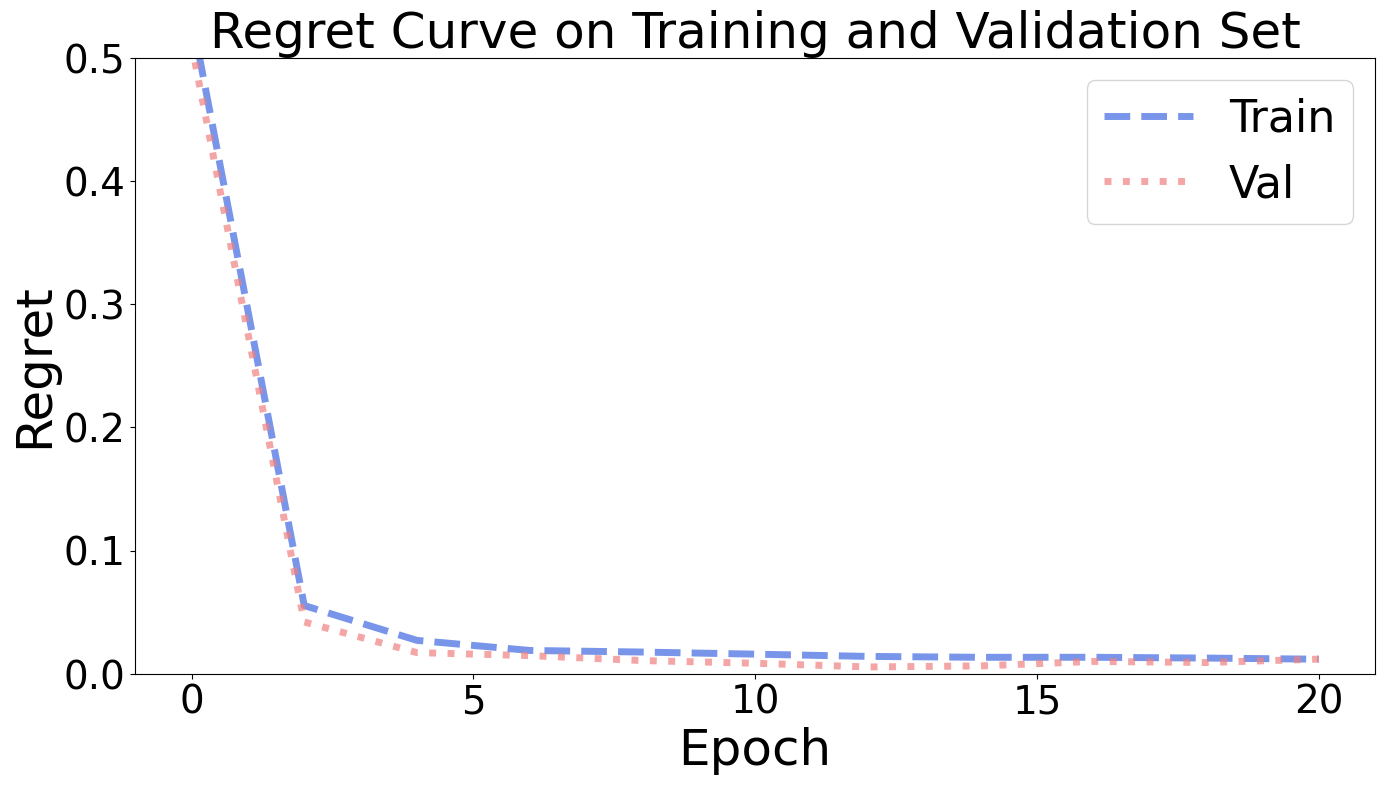

In [14]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NNLS Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import nnlsConeAlignedCosine
# init loss
ca_cos = nnlsConeAlignedCosine(optmodel, conecheck=False, processes=1)

Num of cores: 1


In [17]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  46.6025%, Val Regret:  42.6043%


Epoch    1, Loss:  -1.0000:  10%|█████▌                                                 | 2/20 [00:05<00:35,  1.97s/it]

Epoch   2, Train Regret:   3.6418%, Val Regret:   3.4839%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:09<00:31,  1.98s/it]

Epoch   4, Train Regret:   1.7156%, Val Regret:   1.6549%


Epoch    5, Loss:  -1.0000:  30%|████████████████▌                                      | 6/20 [00:14<00:27,  1.97s/it]

Epoch   6, Train Regret:   1.2127%, Val Regret:   1.1408%


Epoch    7, Loss:  -0.9999:  40%|██████████████████████                                 | 8/20 [00:18<00:23,  1.98s/it]

Epoch   8, Train Regret:   1.0979%, Val Regret:   0.8010%


Epoch    9, Loss:  -1.0000:  50%|███████████████████████████                           | 10/20 [00:22<00:19,  1.99s/it]

Epoch  10, Train Regret:   0.9648%, Val Regret:   0.6975%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [00:26<00:15,  1.99s/it]

Epoch  12, Train Regret:   0.9380%, Val Regret:   0.7567%


Epoch   13, Loss:  -1.0000:  70%|█████████████████████████████████████▊                | 14/20 [00:31<00:11,  1.99s/it]

Epoch  14, Train Regret:   0.8941%, Val Regret:   0.7810%


Epoch   15, Loss:  -1.0000:  80%|███████████████████████████████████████████▏          | 16/20 [00:35<00:08,  2.01s/it]

Epoch  16, Train Regret:   0.9959%, Val Regret:   0.7699%


Epoch   17, Loss:  -1.0000:  90%|████████████████████████████████████████████████▌     | 18/20 [00:39<00:04,  2.00s/it]

Epoch  18, Train Regret:   0.8294%, Val Regret:   0.5898%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.12s/it]


Epoch  19, Loss:  -1.0000, Train Regret:   0.8100%, Val Regret:   0.5555%

Evaluation:
Test Regret: 0.7399%
Training Elapsed Time: 7.38 Sec


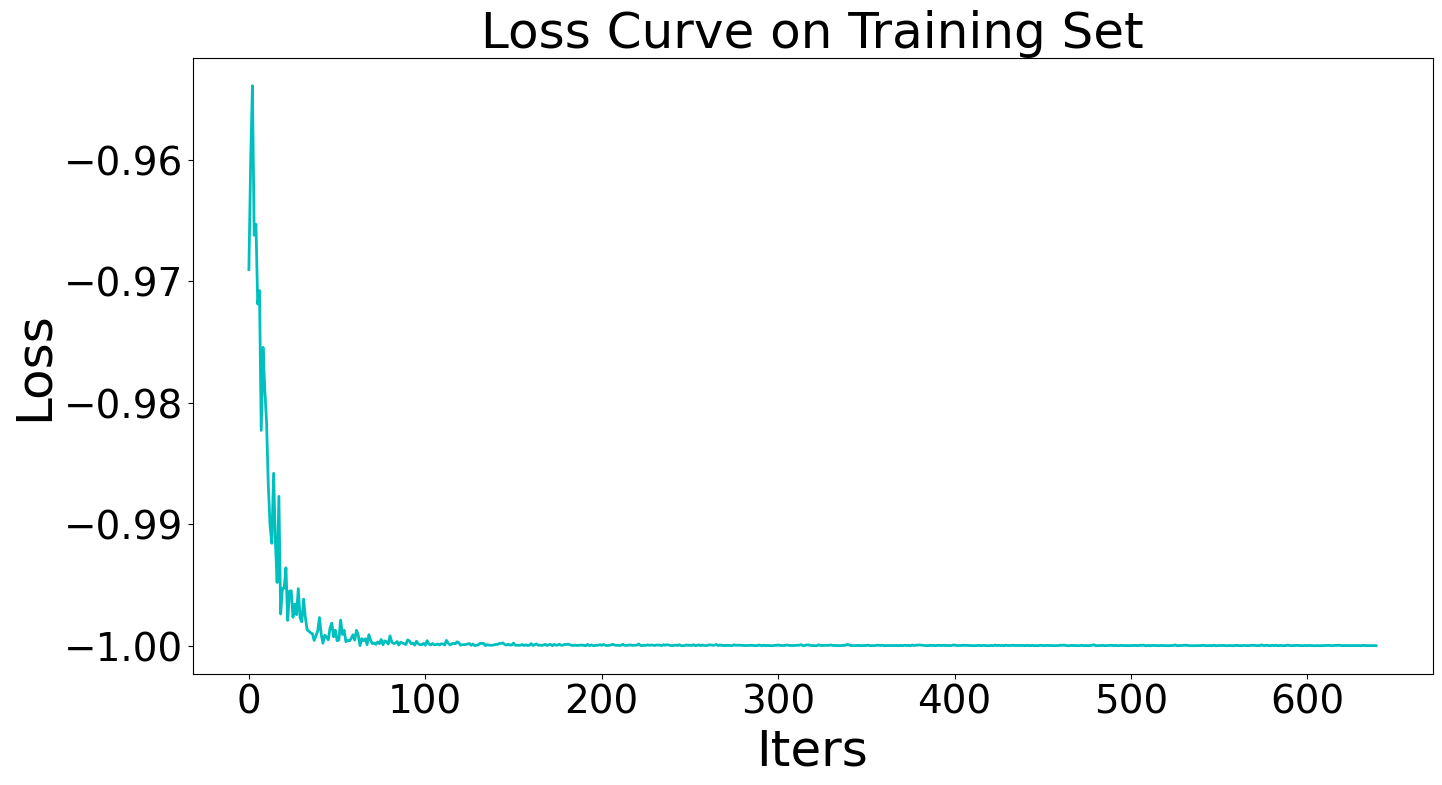

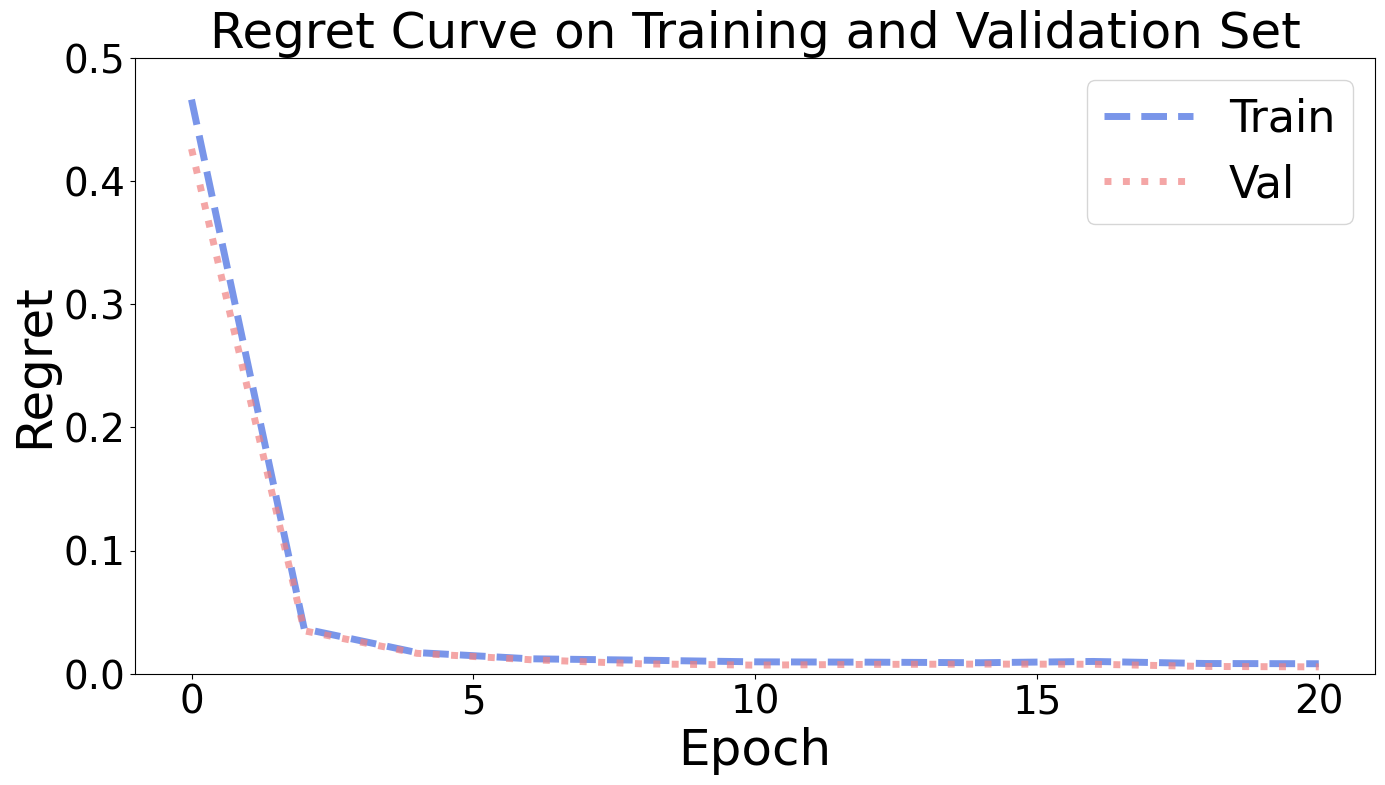

In [18]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Vector Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import avgVectConeAlignedCosine

# init loss
ca_cos = avgVectConeAlignedCosine(optmodel)

In [21]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  57.8398%, Val Regret:  59.5138%


Epoch    1, Loss:  -0.7096:  10%|█████▌                                                 | 2/20 [00:05<00:30,  1.71s/it]

Epoch   2, Train Regret:   3.1184%, Val Regret:   2.7306%


Epoch    3, Loss:  -0.7996:  20%|███████████                                            | 4/20 [00:08<00:27,  1.69s/it]

Epoch   4, Train Regret:   2.4695%, Val Regret:   3.1682%


Epoch    5, Loss:  -0.7806:  30%|████████████████▌                                      | 6/20 [00:12<00:23,  1.69s/it]

Epoch   6, Train Regret:   2.5967%, Val Regret:   3.0291%


Epoch    7, Loss:  -0.8015:  40%|██████████████████████                                 | 8/20 [00:16<00:20,  1.68s/it]

Epoch   8, Train Regret:   2.6221%, Val Regret:   2.6387%


Epoch    9, Loss:  -0.8154:  50%|███████████████████████████                           | 10/20 [00:19<00:17,  1.71s/it]

Epoch  10, Train Regret:   2.7402%, Val Regret:   2.9622%


Epoch   11, Loss:  -0.8051:  60%|████████████████████████████████▍                     | 12/20 [00:23<00:13,  1.69s/it]

Epoch  12, Train Regret:   2.7295%, Val Regret:   3.0182%


Epoch   13, Loss:  -0.8069:  70%|█████████████████████████████████████▊                | 14/20 [00:26<00:10,  1.68s/it]

Epoch  14, Train Regret:   2.5180%, Val Regret:   2.7633%


Epoch   15, Loss:  -0.8339:  80%|███████████████████████████████████████████▏          | 16/20 [00:30<00:06,  1.68s/it]

Epoch  16, Train Regret:   2.5370%, Val Regret:   2.6962%


Epoch   17, Loss:  -0.8654:  90%|████████████████████████████████████████████████▌     | 18/20 [00:34<00:03,  1.71s/it]

Epoch  18, Train Regret:   2.7131%, Val Regret:   2.9354%


Epoch   19, Loss:  -0.7932: 100%|██████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.82s/it]


Epoch  19, Loss:  -0.7932, Train Regret:   2.6230%, Val Regret:   2.7830%

Evaluation:
Test Regret: 3.1556%
Training Elapsed Time: 1.73 Sec


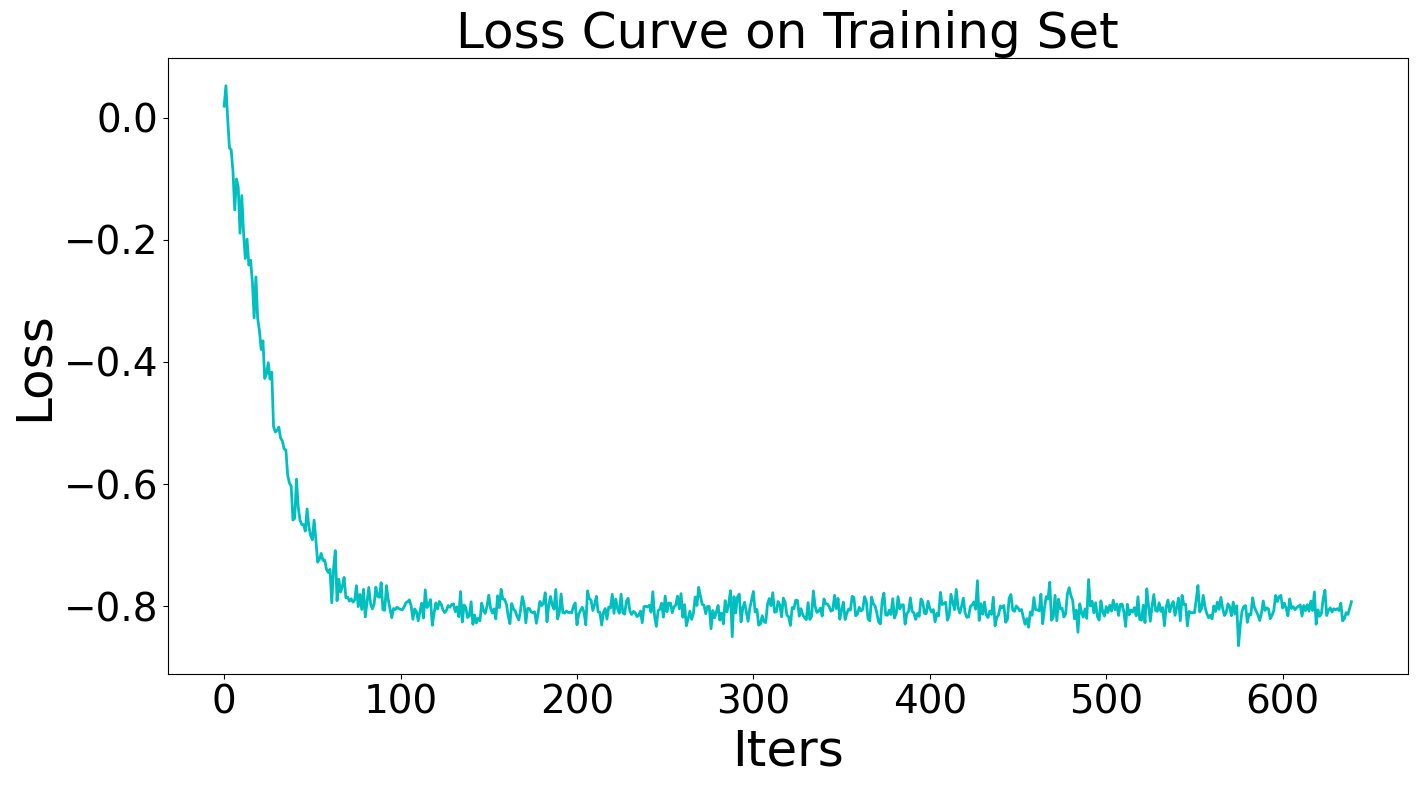

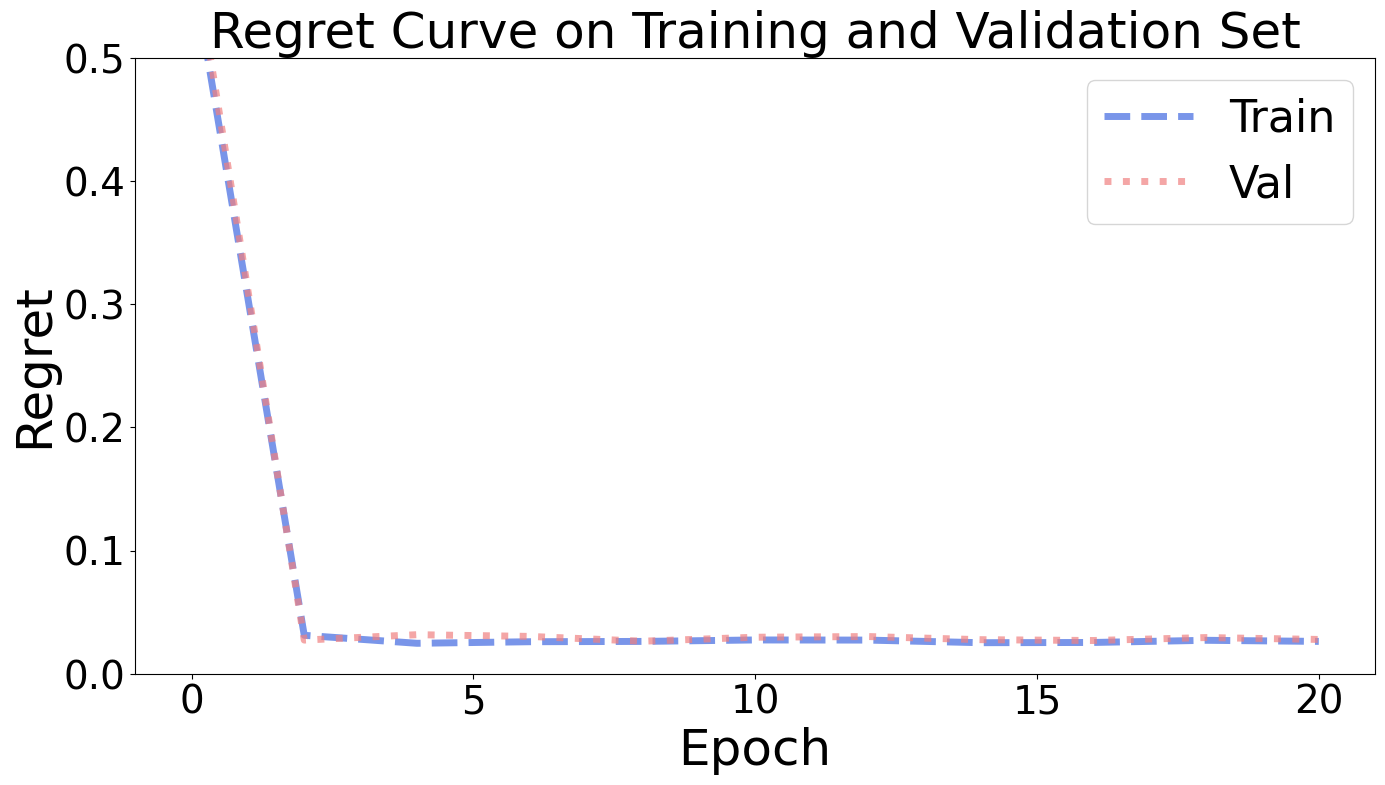

In [22]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [23]:
# init model
reg = LinearRegression()

In [24]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [25]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  46.2136%, Val Regret:  34.0378%


Epoch    1, Loss:  -0.6493:  10%|█████▌                                                 | 2/20 [00:05<00:35,  1.96s/it]

Epoch   2, Train Regret:   2.6698%, Val Regret:   2.9094%


Epoch    3, Loss:  -0.6663:  20%|███████████                                            | 4/20 [00:09<00:31,  1.96s/it]

Epoch   4, Train Regret:   2.4332%, Val Regret:   2.9408%


Epoch    5, Loss:  -0.7091:  30%|████████████████▌                                      | 6/20 [00:14<00:27,  1.94s/it]

Epoch   6, Train Regret:   2.9812%, Val Regret:   2.8725%


Epoch    7, Loss:  -0.6972:  40%|██████████████████████                                 | 8/20 [00:18<00:22,  1.91s/it]

Epoch   8, Train Regret:   2.6291%, Val Regret:   2.7863%


Epoch    9, Loss:  -0.6848:  50%|███████████████████████████                           | 10/20 [00:21<00:18,  1.90s/it]

Epoch  10, Train Regret:   2.6616%, Val Regret:   3.0817%


Epoch   11, Loss:  -0.6886:  60%|████████████████████████████████▍                     | 12/20 [00:26<00:14,  1.86s/it]

Epoch  12, Train Regret:   2.8943%, Val Regret:   2.8805%


Epoch   13, Loss:  -0.7085:  70%|█████████████████████████████████████▊                | 14/20 [00:29<00:11,  1.88s/it]

Epoch  14, Train Regret:   2.8563%, Val Regret:   3.2616%


Epoch   15, Loss:  -0.6977:  80%|███████████████████████████████████████████▏          | 16/20 [00:34<00:07,  1.85s/it]

Epoch  16, Train Regret:   2.8291%, Val Regret:   2.9511%


Epoch   17, Loss:  -0.7129:  90%|████████████████████████████████████████████████▌     | 18/20 [00:38<00:03,  1.89s/it]

Epoch  18, Train Regret:   2.8013%, Val Regret:   3.3092%


Epoch   19, Loss:  -0.6906: 100%|██████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.03s/it]


Epoch  19, Loss:  -0.6906, Train Regret:   2.7984%, Val Regret:   2.6962%

Evaluation:
Test Regret: 3.2972%
Training Elapsed Time: 5.23 Sec


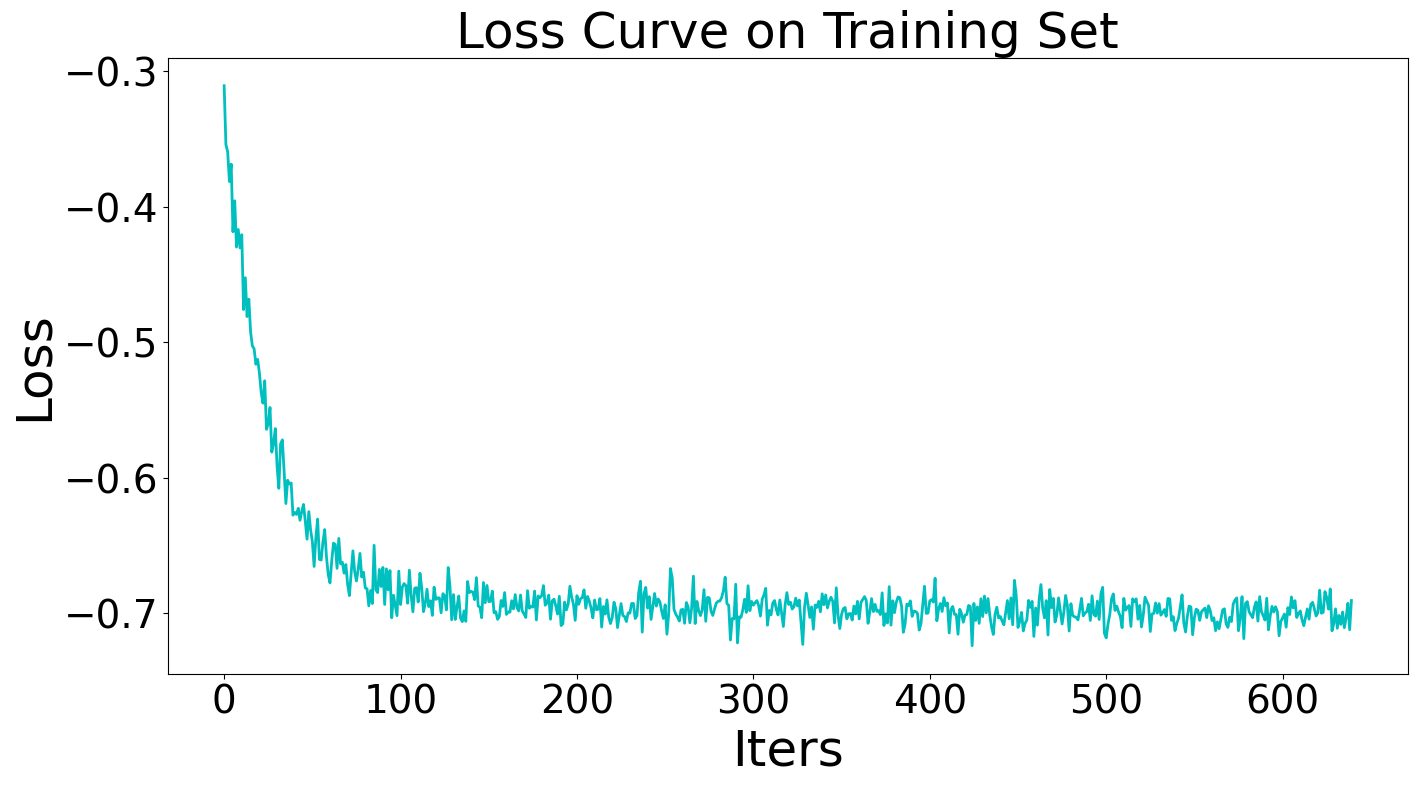

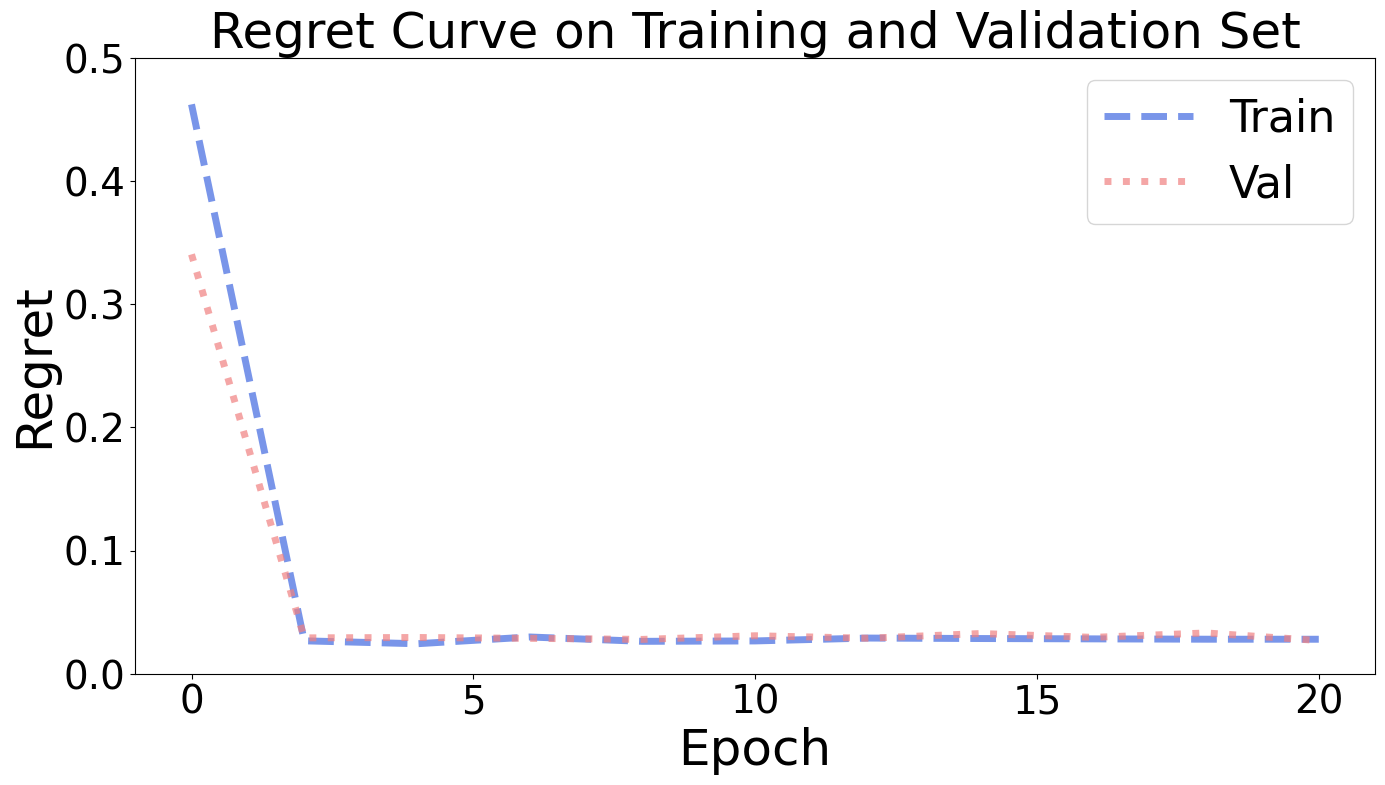

In [26]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method

In [27]:
# init model
reg = LinearRegression()

In [28]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [29]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  42.5053%, Val Regret:  43.7341%


Epoch    1, Loss:  -0.9822:  10%|█████▌                                                 | 2/20 [00:05<00:30,  1.71s/it]

Epoch   2, Train Regret:   6.3699%, Val Regret:   6.8923%


Epoch    3, Loss:  -0.9948:  20%|███████████                                            | 4/20 [00:08<00:27,  1.71s/it]

Epoch   4, Train Regret:   2.8508%, Val Regret:   3.0067%


Epoch    5, Loss:  -0.9936:  30%|████████████████▌                                      | 6/20 [00:12<00:24,  1.72s/it]

Epoch   6, Train Regret:   2.6171%, Val Regret:   2.2148%


Epoch    7, Loss:  -0.9986:  40%|██████████████████████                                 | 8/20 [00:16<00:20,  1.70s/it]

Epoch   8, Train Regret:   2.6674%, Val Regret:   2.0260%


Epoch    9, Loss:  -0.9890:  50%|███████████████████████████                           | 10/20 [00:19<00:17,  1.71s/it]

Epoch  10, Train Regret:   2.5351%, Val Regret:   2.0347%


Epoch   11, Loss:  -0.9985:  60%|████████████████████████████████▍                     | 12/20 [00:23<00:13,  1.71s/it]

Epoch  12, Train Regret:   2.5949%, Val Regret:   2.2137%


Epoch   13, Loss:  -0.9953:  70%|█████████████████████████████████████▊                | 14/20 [00:27<00:10,  1.71s/it]

Epoch  14, Train Regret:   2.6289%, Val Regret:   2.4981%


Epoch   15, Loss:  -0.9932:  80%|███████████████████████████████████████████▏          | 16/20 [00:30<00:06,  1.71s/it]

Epoch  16, Train Regret:   2.7491%, Val Regret:   2.7739%


Epoch   17, Loss:  -0.9981:  90%|████████████████████████████████████████████████▌     | 18/20 [00:34<00:03,  1.70s/it]

Epoch  18, Train Regret:   2.7772%, Val Regret:   2.8143%


Epoch   19, Loss:  -0.9984: 100%|██████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.84s/it]


Epoch  19, Loss:  -0.9984, Train Regret:   3.0036%, Val Regret:   3.0024%

Evaluation:
Test Regret: 3.1901%
Training Elapsed Time: 1.79 Sec


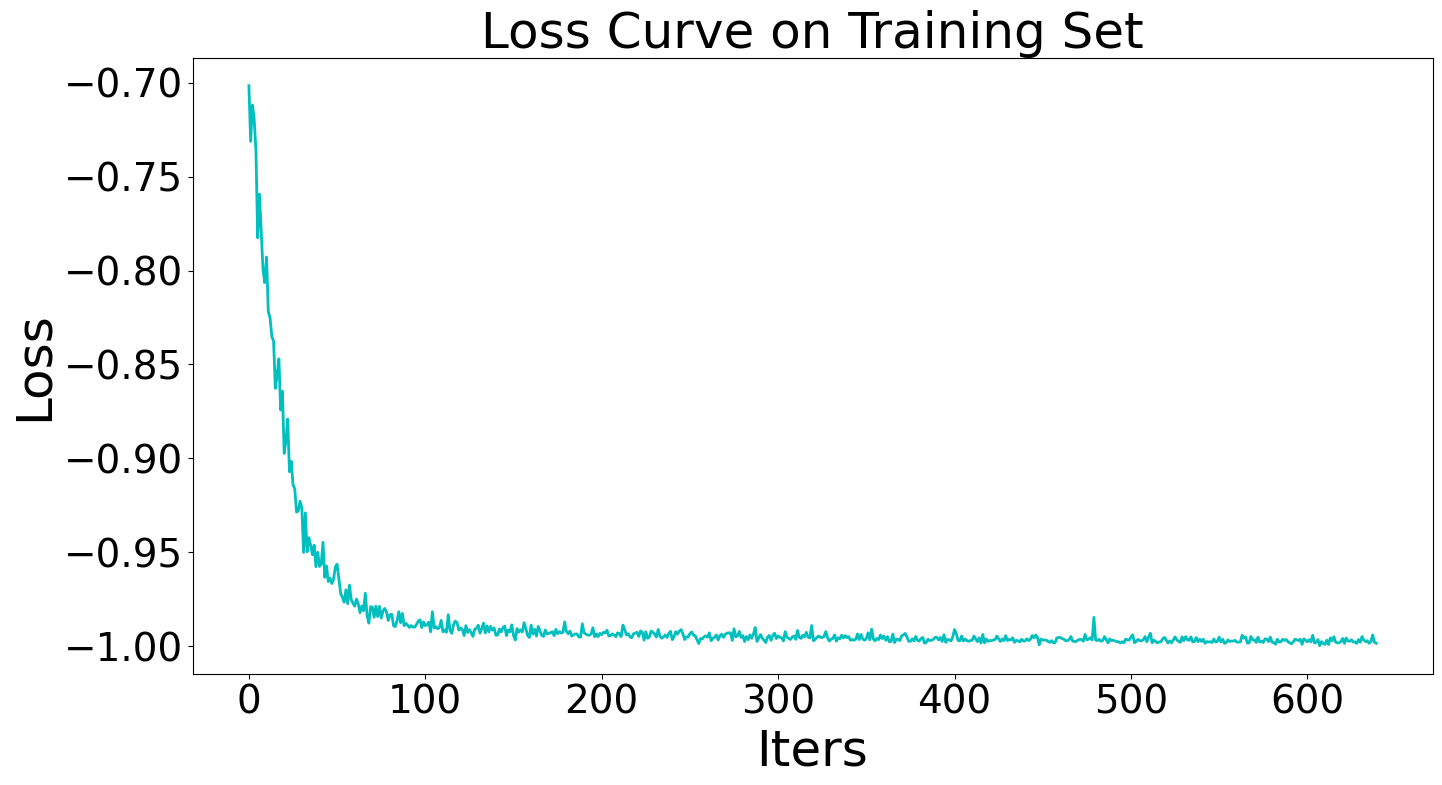

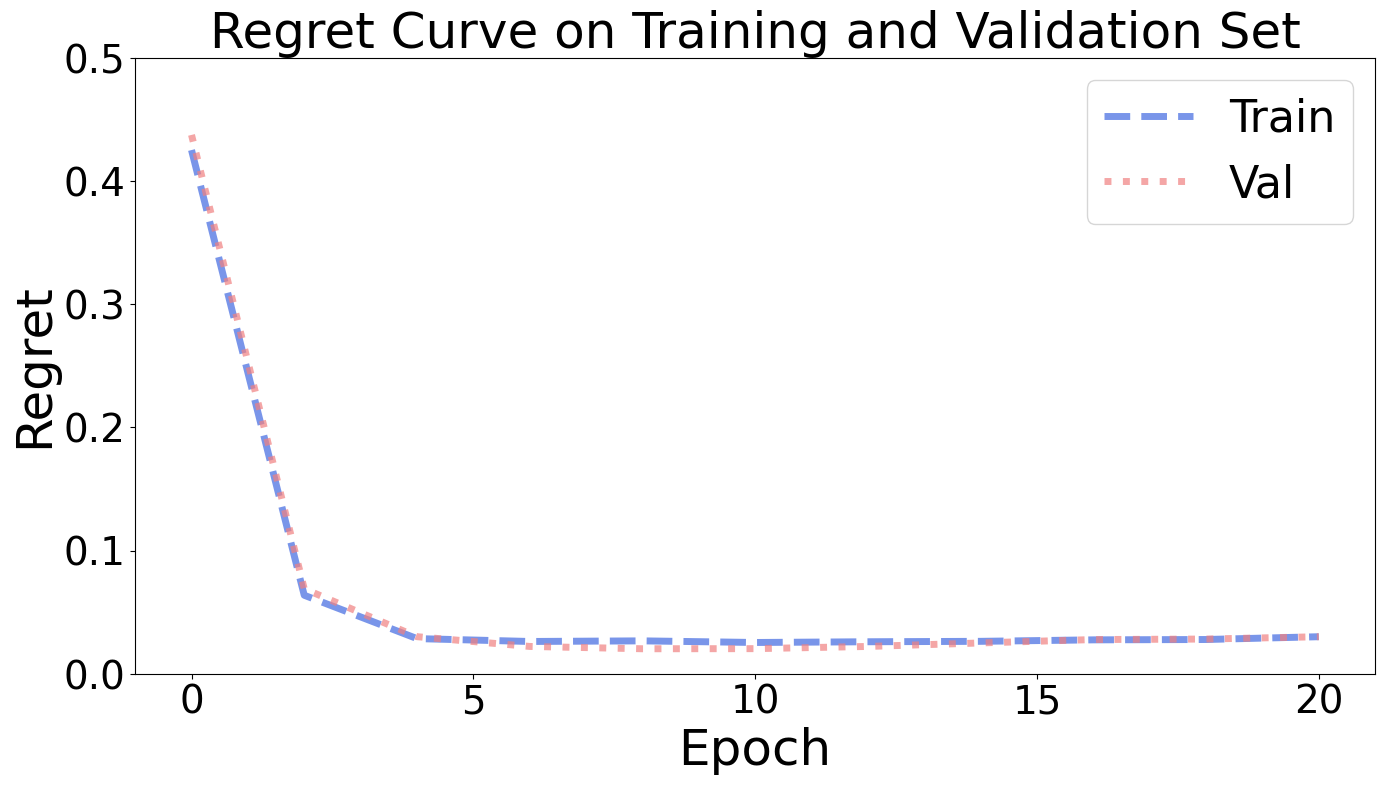

In [30]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)